In [1]:
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import random
from torch.autograd import Variable
from matplotlib import pyplot as plt
import seaborn as sns
from torch import nn
from collections import OrderedDict

import torchmetrics

import nn_architectures.feed_forward_net as feed_forward_net
from nn_architectures import utils

In [2]:
def f(x):
    return x**2


def f2(x):
    return (x-2)**2


def g(y):
    return y**2


def g2(y):
    return (y-1)**2

In [3]:
def loss_laplace(model, inp: torch.tensor):
    x = inp[:, 0].unsqueeze(0).T
    y = inp[:, 1].unsqueeze(0).T
    # Perda domínio
    loss_dom = (utils.dxx(model, x, y) + utils.dyy(model, x, y) - 4)**2
    L1 = loss_dom.sum()*0.001**2

    # Perda contorno y
    zero = torch.zeros(y.size()[0], 1, requires_grad=True)
    x_zero = torch.cat([x, zero], axis=1)
    loss_y0 = (model(x_zero) - x.detach().clone().apply_(f))**2
    L2 = loss_y0.sum()*0.001**2

    one = torch.ones(y.size()[0], 1, requires_grad=True)
    x_two = x_zero = torch.cat([x, one*2], axis=1)
    loss_yb = (model(x_two) - x.detach().clone().apply_(f2))**2
    L3 = loss_yb.sum()*0.001**2

    # Perda contorno x
    zero = torch.zeros(x.size()[0], 1, requires_grad=True)
    y_zero = torch.cat([zero, y], axis=1)
    loss_x0 = (model(y_zero) - y.detach().clone().apply_(g))**2
    L4 = loss_x0.sum()*0.001**2

    one = torch.ones(x.size()[0], 1, requires_grad=True)
    y_one = torch.cat([one, y], axis=1)
    loss_xa = (model(y_one) - y.detach().clone().apply_(g2))**2
    L5 = loss_xa.sum()*0.001**2

    return L1, L2, L3, L4, L5

In [4]:
def u(x, t):
    """Solução analítica da equação de laplace

    Parameters
    ----------
    x : torch.Tensor
        _description_
    t : torch.Tensor
        _description_

    Returns
    -------
    torch.Tensor
        _description_
    """
    sol = (x-t)**2
    return sol


In [5]:
torch.set_default_dtype(torch.float64)

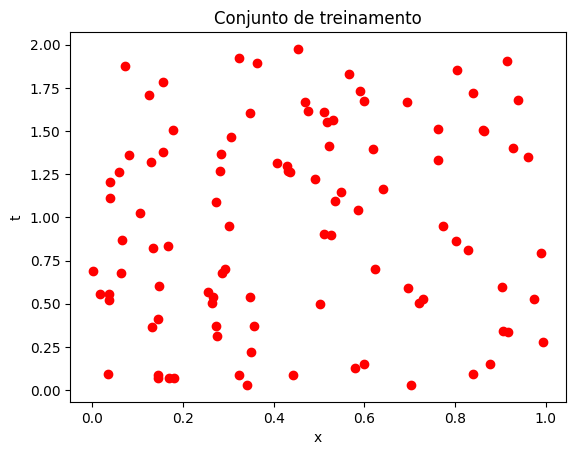

In [6]:
### Amostra para entrada:
### L: tamanho da amostra
L=100
a = 1
b = 2
x = np.random.uniform(0,a, size=L) ##
t = np.random.uniform(0,b, size=L)


plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Conjunto de treinamento')
plt.show()

In [7]:
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T)

In [8]:
net = feed_forward_net.Net(layers=[2, 100, 100, 100, 100, 1],
              activation_function='relu',
              loss=loss_laplace,
              optimizer=optim.Adamax,
              optimizer_params={'lr': 0.001})

epochs_array, loss_array = net.fit(x=inp, epochs=10000, nbatches=1, output_loss=True)

/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/nn_architectures/utils.py:111: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  x_1 = torch.cat([x_plus_h.unsqueeze(0), y.unsqueeze(0)]).T


Epoch 1000, Loss 8.395142248647241e-08
Epoch 2000, Loss 2.0271110933140595e-08
Epoch 3000, Loss 7.453721114025136e-09
Epoch 4000, Loss 4.85599073077895e-09
Epoch 5000, Loss 2.0082487689416188e-09
Epoch 6000, Loss 1.3345759242634268e-09
Epoch 7000, Loss 5.184467693156464e-09
Epoch 8000, Loss 9.354505342411217e-10
Epoch 9000, Loss 8.200933058162469e-10
Epoch 10000, Loss 7.226557363732596e-10


In [9]:
#net.predict(x, t)

In [10]:
utils.metricas(net, u, a, b)

(tensor(2.1581e-07), tensor(0.0003))

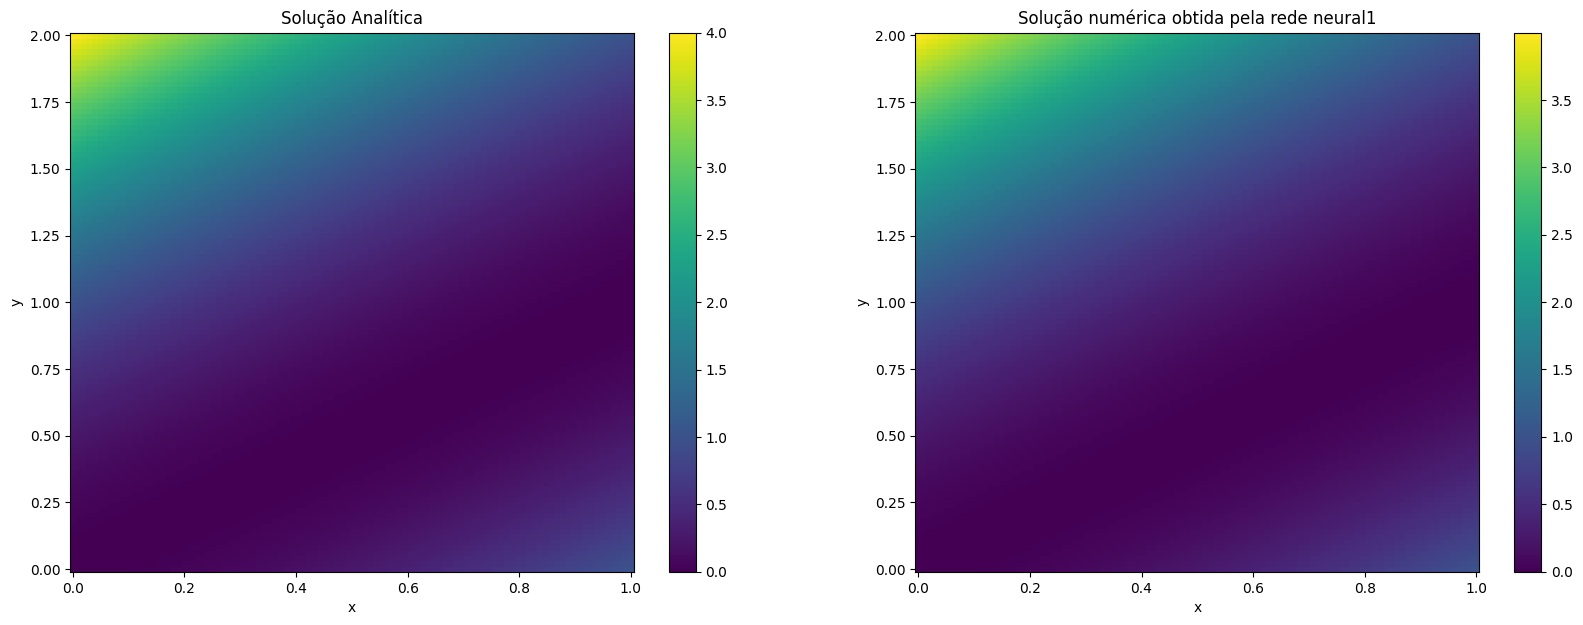

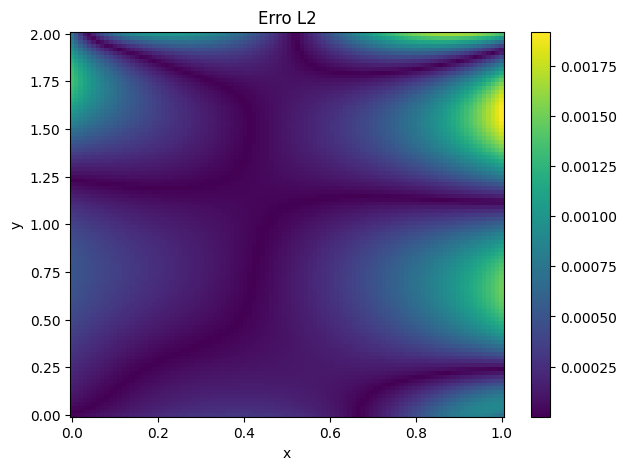

In [11]:
utils.plot_solucao_erro_l2(net, u, a, b)